In [1]:
%matplotlib inline

In [2]:
from grale.all import *
import pickle
from scipy.optimize import minimize

feedback.setDefaultFeedback("notebook")

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec


In [3]:
# There are the relevant redshifts, and the cosmological model we'll use
z_lens = 0.099
z_s = 1.241

cosm = cosmology.Cosmology(0.7, 0.3, 0, 0.7)
cosmology.setDefaultCosmology(cosm)
D = cosm.getAngularDiameterDistance

In [4]:
# Let's load the roughly identified galaxy shapes that we saved to a file
galaxies = images.ImagesData.load("galaxies.imgdata")

In [5]:
# Helper function to draw an ellipse
def drawEllipse(x0, y0, a, b, angle):
    theta = np.linspace(0,2*np.pi,100)
    x = a*np.cos(theta)
    y = b*np.sin(theta)
    phi = angle
    x2 = x*np.cos(phi)+y*np.sin(phi)
    y2 = -x*np.sin(phi)+y*np.cos(phi)
    plt.plot(x2 + x0, y2 + y0)

In [6]:
# For each galaxy shape that was saved in the imgdata file, we're going to fit
# an ellipse to it. For a set of points, and parameters that describe an ellipse,
# this is some estimate for how well the ellipse approximates the points (I'm
# pretty sure there must be better ways of doing this though)
def calcPenalty(pts, params):
    xc, yc, a, b, angle = params
    pts_centered = pts - V(xc, yc)
    R = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle),np.cos(angle)]])
    pts_rot = np.matmul(R,pts_centered.T).T
    angles = np.arctan2(pts_rot[:,1],pts_rot[:,0])
    pred = np.array([a*np.cos(angles), b*np.sin(angles)]).T
    distSquared = np.sum((pts_rot-pred)**2,axis=1)
    return np.sum(distSquared)

In [7]:
# Here, for a specific set of points, the actual optimization is performed
def estimateParameters(pts):
    pts = np.array(pts)
    ctr = (np.max(pts, axis=0) + np.min(pts, axis=0))*0.5
    r = minimize(lambda params: calcPenalty(pts, params), x0 = [ ctr[0], ctr[1], 1, 1, 0.1], method="Nelder-Mead")
    #x0, y0, a, b, angle = r.x
    drawEllipse(*r.x)
    plt.plot(pts[:,0],pts[:,1],".")
    return r.x

Text(value='')

FloatProgress(value=0.0)

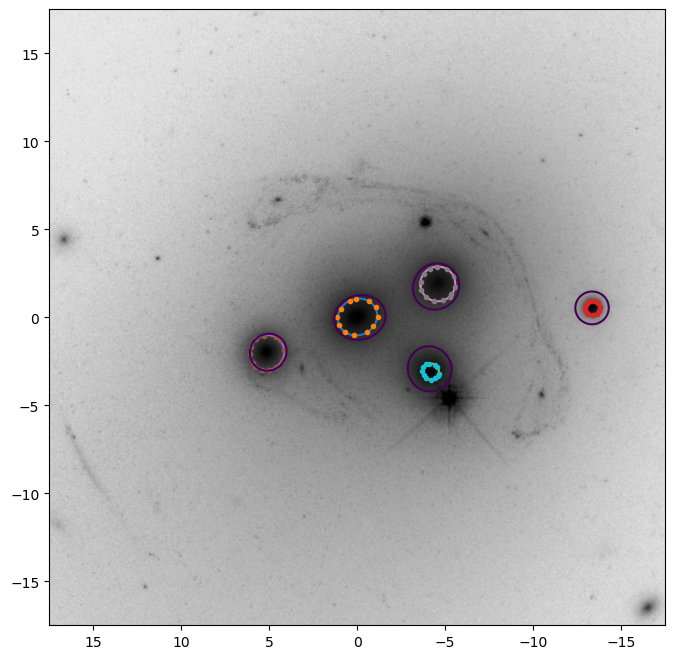

In [8]:
# For each galaxy that was identified, we'll fit the parameters of an ellipse, and
# create an SIE lens with this position, angle, and ellipticity. We'll keep track
# of just a list of these lenses, to be used as basis functions in the inversion script,
# and we'll also create a composite lens from all these basis functions, so that we
# can compare the shape of a contour of the total lens with the individual ellipses.
#
# In the plot you'll see the points to which the ellipse will be fitted, the lines that
# go through them is the resulting fit, and the purple lines correspond to the contour
# of the total lens.

Dd = D(z_lens)

basisFunctions = [ ]
compLensParams = []
plt.figure(figsize=(8,8))
for gal in galaxies.getAllImagePoints():
    pts = [ x["position"]/ANGLE_ARCSEC for x in gal ]
    # optimize 
    x0, y0, a, b, angle = estimateParameters(pts)

    if a < b:
        a, b = b, a
        angle += np.pi/2

    lens = lenses.SIELens(Dd, { "velocityDispersion": 200000, "ellipticity": b/a })
    lensParams = {"angle": 90-angle*180/np.pi, "x": x0*ANGLE_ARCSEC, "y": y0*ANGLE_ARCSEC, "factor": 1, "lens": lens}
    compLensParams.append(lensParams)

    basisFunctions.append(lenses.CompositeLens(Dd, [lensParams]))
    
compLens = lenses.CompositeLens(Dd, compLensParams)
li = plotutil.LensInfo(compLens, size=35*ANGLE_ARCSEC)
plt.imshow(plt.imread("background_35x35_gray_inv.png"), extent=[17.5,-17.5,-17.5,17.5])
plotutil.plotDensityContours(li, levels=[7.5])
plt.gca().invert_xaxis()

In [9]:
# Write the list of SIE basis functions to a file. Note that each basisfunction was
# wrapped in a CompositeLens so that a rotation angle could be specified. In this
# composite lens the SIE was also re-centered, so in the inversion script itself
# we don't need to specify a specific center anymore for a basis function, just
# (0,0)
pickle.dump(basisFunctions, open("siebasisfunctions.pickle","wb"))

### At this point, you need to run the inversion script!

It uses the SIE basis functions together with a course grid of Plummers to approximate
a solution.

In [10]:
# This is copy-paste (apart from the null space) from the inversion script, so
# we can use the inversion workspace to inspect the result

regionSize = 30*ANGLE_ARCSEC
regionCenter = V(-2,0)*ANGLE_ARCSEC
iws = inversion.InversionWorkSpace(z_lens, regionSize=regionSize, regionCenter=regionCenter)

def readInputFile(fileName):
    # This is what I used in the overlay as well
    ctrRa, ctrDec = 330.472325, -59.9454361111111

    def la(line):
        # e.g.: Ah4 330.47372 -59.94599
        idStr, ra, dec = line.split()
        ra, dec = float(ra), float(dec)
        imgNr = int(idStr[2:])
        group = idStr[1:2]
        srcNr = "A" + group # for point images, we're going to use each image group as a separate source

        x, y = images.centerOnPosition(V(ra,dec)*ANGLE_DEGREE, V(ctrRa, ctrDec)*ANGLE_DEGREE)
        return { "x": x, "y": y, "z": z_s, "srcnr": srcNr, "imgnr": imgNr }

    return images.readInputImagesFile(fileName, True, la)

imgList = readInputFile("a3827_images.txt")
for i in imgList:
    iws.addImageDataToList(i["imgdata"], i["z"], "pointimages")

In [11]:
# Load the model that was recovered by the inversion procedure
inv = lenses.GravitationalLens.load("inv_hybrid.lensdata")

In [12]:
# Let's calculate the overlap fitness for this lens model - should be roughly the
# same as what you saw in the output of the inversion script
iws.calculateFitness(inv)

([0.0027097], 'pointimageoverlap')

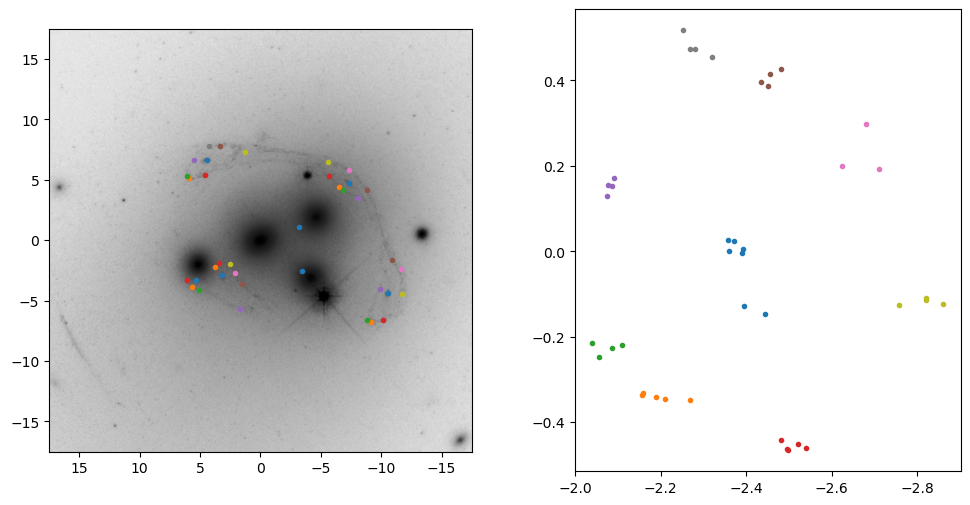

In [13]:
# Let's show the input points for the inversio, as well as the results that you get when
# back-projecting them to the source plane using the lens model that was the result from
# inversion procedure. The overlay is not that good yet, but then again, it's only a
# quick inversion
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(plt.imread("background_35x35_gray_inv.png"), extent=[17.5,-17.5,-17.5,17.5])
plotutil.plotImagesData(imgList)
plt.subplot(1,2,2)
plotutil.plotImagesData(iws.backProject(inv))
plt.gca().set_aspect("equal")
plt.gca().invert_xaxis()

Text(value='')

FloatProgress(value=0.0)

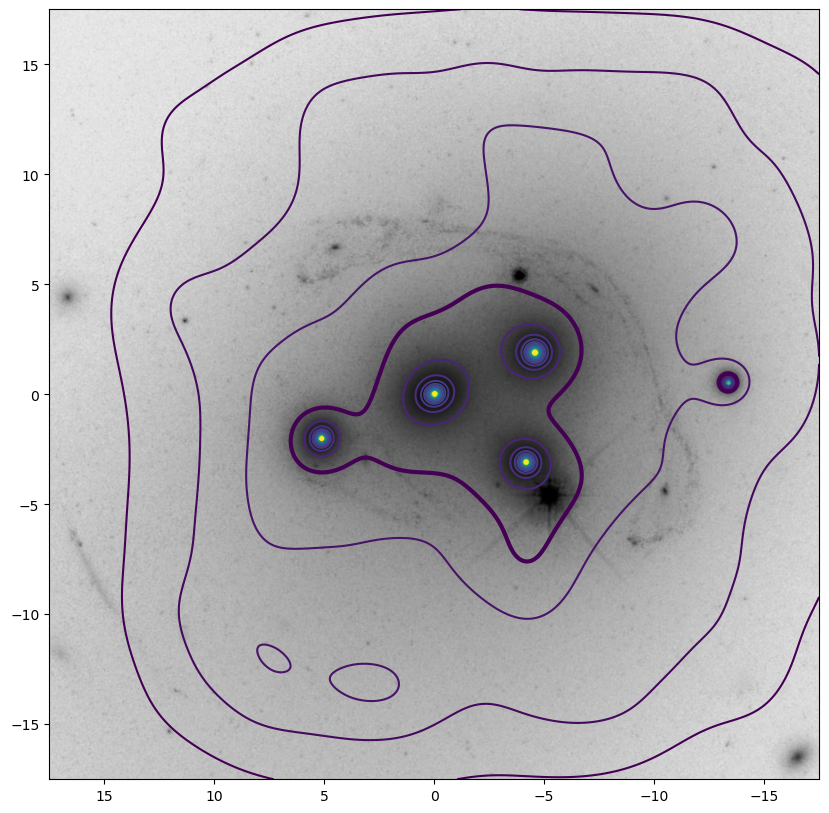

In [14]:
# And here is the mass map of the model
sigmaCrit = lenses.getCriticalDensity(D(z_lens), D(z_s), D(z_lens, z_s))

invLi = plotutil.LensInfo(inv, size=35*ANGLE_ARCSEC, zd=z_lens, zs=z_s)

plt.figure(figsize=(10,10))
plt.imshow(plt.imread("background_35x35_gray_inv.png"), extent=[17.5,-17.5,-17.5,17.5])
plotutil.plotDensityContours(invLi, levels=np.arange(0.25, 10, 0.25), densityUnit=sigmaCrit)
plotutil.plotDensityContours(invLi, levels=[1], densityUnit=sigmaCrit, linewidths=3)
plt.gca().invert_xaxis()